In [1]:
import os, time, errno
import torch, tables
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']='0'
savedir = '16x16-resnet-mlp'

In [3]:
T = 10 # time buckets

hdf5 = tables.open_file('captures/fei/R1_E3_AMES_200min_200f_14l_rgb.h5','r')
hdf5 = hdf5.root
#print(np.array(hdf5['image_classes'])[0])
#raise
#label_index = np.array(hdf5['image_classes']).astype(int)

try:
    dataset = np.load('captures/fei/cache.npy')
    #dataset = np.load('captures/200807/glia_data.npy')
except FileNotFoundError:

    data = []
    for i in range(7):
        print('.',end='')
        batch = np.array(hdf5['data'][i*400:(i+1)*400])
        batch = batch.reshape(-1,T,int(batch.shape[1]/T),64,64,6).sum(2).astype(np.float32) # binning
        data.append(batch)
        
    dataset = np.concatenate(data,axis=0)
    dataset = np.moveaxis(dataset,[0,1,2,3,4],[0,1,3,4,2])
    np.save('captures/fei/cache.npy', dataset)
    
classes = np.array([np.array(itm.decode('utf-8').split('"'))[[1,3]].astype(np.int32)
                    for itm in np.array(hdf5['image_classes'].read())])

# Presented targets

In [4]:
imgs = hdf5["images"][0:100]
y,x = np.where(np.mean(imgs, axis=(0,3))>5)
xleft, xright, ytop, ybot = min(x), max(x), min(y), max(y)

images = hdf5["images"][:,ytop:ybot,xleft:xright]

tiny_images = []
for i in range(len(images)):
    tiny_images.append(cv2.resize(images[i],(64,64)))
images = np.stack(tiny_images)

# Model

In [5]:
class Block(torch.nn.Module):
    def __init__(self, filters):
        super(Block, self).__init__()

        self.block = torch.nn.Sequential(
            torch.nn.Linear(filters, filters, bias=False),
            torch.nn.BatchNorm1d(filters), torch.nn.ReLU(),
            torch.nn.Linear(filters, filters, bias=False),
            torch.nn.BatchNorm1d(filters))

    def forward(self, x):
        return F.relu(x + self.block(x))
    
class ResNet(torch.nn.Module):
    def __init__(self, filters=2048):
        super(ResNet, self).__init__()
        self.filters = filters
        
        self.w_in = torch.nn.Linear(10*6*16*16,self.filters, bias=False)
        #self.w_in = torch.nn.Linear(10*6*8*8,self.filters, bias=False)
        
        self.resnet = torch.nn.ModuleList()
        for i in range(18): self.resnet.append(Block(filters))
            
        self.w_out =  torch.nn.Linear(self.filters, 64*64, bias=True)
        
        for name, parm in self.named_parameters():
            if name.endswith('weight'): torch.nn.init.normal_(parm, 0, .01)
            if name.endswith('bias'): torch.nn.init.constant_(parm, 0.0)
    
    def forward(self, x):
        #x = x.view(-1,10*6,64,64)[:,:,::8,::8].contiguous()
        x = x.view(-1,10*6,64,64)[:,:,::4,::4].contiguous()
        zx = F.relu(self.w_in(x.view(-1,10*6*16*16)))
        for layer in self.resnet: zx = layer(zx)
        return torch.sigmoid(self.w_out(zx).view(-1,64,64))

# Fit

In [6]:
data = torch.tensor(dataset)/30. # scaling
targets = torch.tensor(images).float().mean(3)/255.

In [7]:
train_data = data[[i for i in range(2800) if (i+1)%5 != 0]]
val_data = data[slice(4,2800,10)]
test_data = data[slice(9,2800,10)]

train_targets = targets[[i for i in range(2800) if (i+1)%5 != 0]]
val_targets = targets[slice(4,2800,10)]
test_targets = targets[slice(9,2800,10)]

In [8]:
batch_size = 100

model = ResNet().cuda()
count = sum([np.prod(parm.shape) for parm in model.parameters() if parm.requires_grad])
print('Initialized a graph with {} parameters'.format(count))

train_history = []
val_history = []

model.eval()
loss = 0.
for i in np.random.permutation(len(val_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).sum(1).mean()
val_history.append(loss/(len(val_data)//batch_size))
print('Initial Loss: {:2f}'.format(val_history[-1]))

Initialized a graph with 190992384 parameters
Initial Loss: 4.110739


In [9]:
batch_size = 100
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

try:
    print('epoch\ttrain loss\ttest loss\ttime\t\tutime')
    t0 = time.time()
    for epoch in range(500):
        model.train()
        loss_train = 0
        for i in np.random.permutation(len(train_data)//batch_size):
            start, end = i*batch_size, (i+1)*batch_size
            x,z = train_data[start:end].cuda(), train_targets[start:end].cuda()
            loss = ((model(x) - z)**2).sum(1).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.detach()
        train_history.append(loss_train/(len(train_data)//batch_size))

        if epoch % 1 == 0:
            t1 = time.time()
            model.eval()
            loss = 0.
            for i in range(len(val_data)//batch_size):
                start, end = i*batch_size, (i+1)*batch_size
                x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
                loss += ((model(x).detach() - z)**2).sum(1).mean()
            val_history.append(loss/(len(val_data)//batch_size))
            print('{:d}\t{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(epoch,train_history[-1],val_history[-1],time.time()-t0, time.time()-t1))
            t0 = time.time()
            
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print('Finished')

epoch	train loss	test loss	time		utime
0	1.933367	1.655808	1.529010	0.086345
1	1.085772	1.510915	1.503642	0.087382
2	0.938179	1.073777	1.504284	0.087163
3	0.870228	1.087578	1.504605	0.087669
4	0.809665	1.138393	1.505106	0.086457
5	0.776774	1.242362	1.509284	0.090662
6	0.748984	0.947691	1.505152	0.086531
7	0.710457	0.965236	1.505038	0.088003
8	0.673612	0.929382	1.508490	0.089293
9	0.642423	1.123056	1.506639	0.087491
10	0.624454	1.140042	1.505334	0.086245
11	0.602546	0.945636	1.506552	0.090670
12	0.580298	0.943829	1.509162	0.092585
13	0.563210	0.924675	1.507921	0.085890
14	0.534773	1.085368	1.509510	0.093989
15	0.511344	0.858909	1.509569	0.092721
16	0.496330	0.971299	1.507811	0.087811
17	0.477635	0.885008	1.508319	0.087726
18	0.460697	0.821483	1.508882	0.088272
19	0.443291	0.879585	1.508935	0.086996
20	0.429573	0.883588	1.509432	0.090786
21	0.408993	0.934232	1.510418	0.090467
22	0.393131	0.854332	1.511235	0.088865
23	0.379023	0.849258	1.509662	0.087376
24	0.361833	1.148881	1.510673	0.086

207	0.032152	0.821393	1.524747	0.091272
208	0.028047	0.936762	1.538094	0.097188
209	0.023665	0.852079	1.525549	0.091646
210	0.018066	0.830697	1.525399	0.077677
211	0.015477	0.838335	1.523168	0.087991
212	0.015030	0.800435	1.521771	0.088114
213	0.013186	0.818359	1.521986	0.090435
214	0.011958	0.863377	1.526507	0.086607
215	0.011827	0.813787	1.529028	0.087322
216	0.011363	0.821309	1.530867	0.087427
217	0.010914	0.841443	1.522897	0.077540
218	0.012939	0.828769	1.522527	0.086977
219	0.013381	0.811229	1.524505	0.087903
220	0.016168	0.853150	1.522893	0.086898
221	0.014738	0.873651	1.528175	0.088214
222	0.014691	0.837955	1.532256	0.090085
223	0.013136	0.838330	1.523652	0.087945
224	0.011382	0.819185	1.532590	0.087710
225	0.012125	0.834938	1.524862	0.091275
226	0.010529	0.859113	1.528973	0.086684
227	0.010973	0.838427	1.527729	0.087984
228	0.010557	0.803236	1.523489	0.093925
229	0.009599	0.806386	1.523547	0.087178
230	0.008983	0.901554	1.527400	0.095428
231	0.009054	0.851847	1.522584	0.087195


412	0.018751	0.806583	1.522643	0.085339
413	0.028383	0.766328	1.522110	0.088496
414	0.024443	0.797588	1.521272	0.086975
415	0.025050	0.773225	1.520505	0.087188
416	0.025156	0.803518	1.524477	0.087110
417	0.022873	0.780665	1.534986	0.093810
418	0.016885	0.810375	1.523678	0.090869
419	0.014487	0.794920	1.524697	0.093082
420	0.011538	0.811841	1.525158	0.081983
421	0.009059	0.763353	1.522827	0.088876
422	0.006894	0.779165	1.521462	0.088209
423	0.005837	0.791517	1.520892	0.087521
424	0.005036	0.760204	1.520840	0.084602
425	0.005055	0.768497	1.522876	0.085737
426	0.004032	0.749640	1.531306	0.085364
427	0.003422	0.785020	1.521674	0.086969
428	0.002920	0.760217	1.521237	0.084898
429	0.002578	0.764410	1.522978	0.088388
430	0.002591	0.754854	1.522131	0.087995
431	0.002591	0.776589	1.521513	0.090530
432	0.002342	0.770271	1.532351	0.091836
433	0.002355	0.752819	1.526090	0.091080
434	0.002293	0.749684	1.531597	0.094832
435	0.002196	0.763145	1.532369	0.087158
436	0.002343	0.770346	1.521034	0.086833


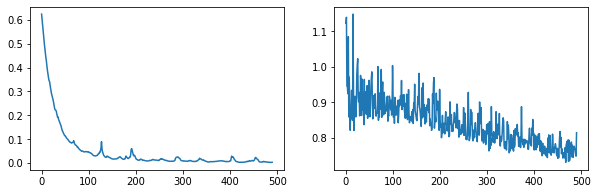

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

ax[0].plot([itm.cpu().numpy() for itm in train_history[10:]])
ax[1].plot([itm.cpu().numpy() for itm in val_history[10:]])

In [12]:
model.eval()
loss = 0.
for i in np.random.permutation(len(test_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = test_data[start:end].cuda(), test_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).view(-1,64*64).sum(1).mean()
print('Final Loss: {:2f}'.format(loss/(len(test_data)//batch_size)))

Final Loss: 51.802711


In [11]:
try:
    os.makedirs(f'final-outputs/{savedir}')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

originals = False
try:
    os.makedirs('final-outputs/originals')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
    originals = True

train_idx = 0
val_idx = 0
test_idx = 0
for i in range(len(data)):
    person, pose = classes[i]
    if (i+1) % 5 != 0: # training data
        prefix = f'train{train_idx}'
        train_idx += 1
    elif (i+1) % 10 == 5: # validation data
        prefix = f'valid{val_idx}'
        val_idx += 1
    else: # (i+1) % 10 == 0 (test data)
        prefix = f'test{test_idx}'
        test_idx += 1
    
    recon = model(data[i].cuda()).detach().cpu().numpy()[0]
    cv2.imwrite(f'final-outputs/{savedir}/{prefix}-person{person}-pose{pose}.png', 255*recon)
    if not originals:
        cv2.imwrite(f'final-outputs/originals/{prefix}-person{person}-pose{pose}.png', 255*targets[i].numpy())

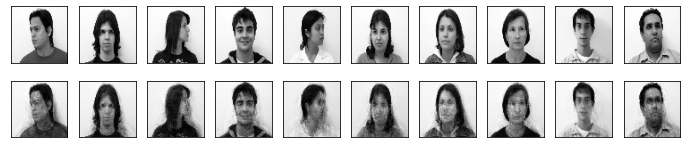

In [13]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))

model.eval()
reconstructions = model(train_data[0:10].cuda()).detach().cpu()
for i in range(10):
    ax[0,i].imshow(train_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i],cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])

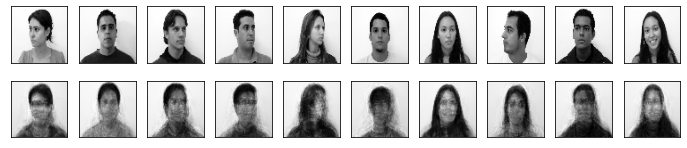

In [14]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))

model.eval()
reconstructions = model(test_data[0:10].cuda()).detach().cpu()
for i in range(10):    
    ax[0,i].imshow(test_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i],cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])